In [1]:
import pickle
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from cartpole_dyna_hyper_sweep import planning_ratios, dyna_iters, ResultTup
import os
import jax
from matplotlib.colors import Normalize
import matplotlib
matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif"})

In [2]:
cpu = jax.devices("cpu")[0]
with open("../base_metrics.pkl", "rb") as f:
    base_metrics = pickle.load(f)

In [3]:
results = {}
equi_results = {}
for pr in planning_ratios:
    for iter_ in dyna_iters:
        path = f"../dyna_pr{pr}_iter{iter_}.pkl"
        path_equi = f"../equi_dyna_pr{pr}_iter{iter_}.pkl"
        if os.path.isfile(path):
            with open(path, "rb") as f:
                results[(pr, iter_)]= jax.device_put(pickle.load(f), cpu)

            with open(path, "rb") as equi_f:
                equi_results[(pr, iter_)]= jax.device_put(pickle.load(equi_f), cpu)

In [4]:
losses = {key: array[1][0] for key, array in results.items()}
results = {key: array[1][1].reshape(128, -1) for key, array in results.items()}
equi_losses = {key: array[1][0] for key, array in equi_results.items()}
equi_results = {key: array[1][1].reshape(128, -1) for key, array in equi_results.items()}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


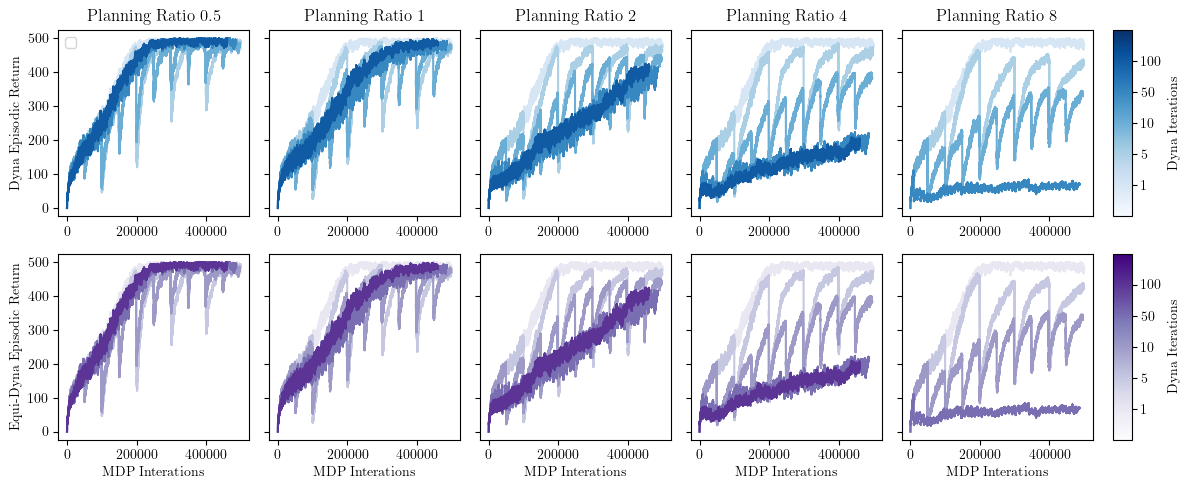

In [5]:
fig, ax = plt.subplots(2, 6, figsize=(12, 5), width_ratios=[1, 1, 1, 1, 1, 0.1])
cmap = plt.cm.Blues
cmap_equi = plt.cm.Purples
for i, pr in enumerate(planning_ratios):
    for j, iter_ in enumerate(dyna_iters):
        try: 
            ax[0, i].plot(results[(pr, iter_)].mean(axis=0), c = cmap((j+1)/(len(dyna_iters)+1)))
            ax[1, i].plot(results[(pr, iter_)].mean(axis=0), c=cmap_equi((j+1)/(len(dyna_iters)+1)))
        except KeyError as e:
            pass
        returns = base_metrics[1].info["returned_episode_returns"].reshape(128, -1)
    # ax[1,i].plot(returns.mean(axis=0), label="Baseline", c= "black", alpha=0.2)
    # ax[0, i].plot(returns.mean(axis=0), label="Baseline", c= "black", alpha=0.2)
    ax[0, i].set_title(f"Planning Ratio {pr}")
    ax[1, i].set_xlabel("MDP Interations")
for i in range(1, 5):
    ax[ 0,i,].set_yticklabels([])
    ax[ 1,i,].set_yticklabels([])
ax[0, 0].set_ylabel("Dyna Episodic Return")
ax[1, 0].set_ylabel("Equi-Dyna Episodic Return")
ax[0, 0].legend()
norm = Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=ax[0, 5])
fig.colorbar(plt.cm.ScalarMappable(cmap=cmap_equi, norm=norm), cax=ax[1,5])
ax[ 0,5,].set_yticks([(i+1)/(len(dyna_iters)+1) for i,_ in enumerate(dyna_iters)], dyna_iters)
ax[ 1,5,].set_yticks([(i+1)/(len(dyna_iters)+1) for i,_ in enumerate(dyna_iters)], dyna_iters)
ax[ 0,5,].set_ylabel("Dyna Iterations")
ax[ 1,5,].set_ylabel("Dyna Iterations")
fig.tight_layout()

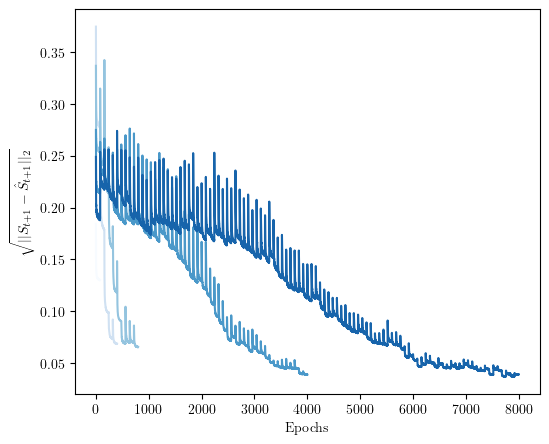

In [6]:
fig, ax = plt.subplots(figsize=(6,5))
for i, iter_ in enumerate(dyna_iters):
    ax.plot(losses[(1, iter_)].reshape(128,-1).mean(axis=0), c=cmap(i/len(dyna_iters)))
    ax.set_xlabel("Epochs")
    ax.set_ylabel("$\sqrt{||S_{t+1} - \hat{S}_{t+1}||_2}$")